<table width=100%>
    <col width=200>
    <tr>
        <td bgcolor="#eee" style="text-align:left" colspan="2">
            <font size="5"><b>Analysis of COVID-19 Infections and Death Data of Brazil</b></font></td>
    <tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>Project creation date:</b> </td>
        <td bgcolor="#eee" style="text-align:left"> May 6, 2020 </td>
    </tr>
        <td bgcolor="#eee" style="text-align:left"><b>Dataset from Ministry of Health:</b> </td>
        <td bgcolor="#eee" style="text-align:left">  <a href="https://covid.saude.gov.br">https://covid.saude.gov.br</a> </td>
    </tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>Project author:</b> </td>
        <td bgcolor="#eee" style="text-align:left"> Ricardo Szczerbacki (<a href="mailto:ricardo@rj1.info">ricardo@rj1.info</a>) </td>
    </tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>Project on Github:</b></td>
        <td bgcolor="#eee" style="text-align:left"><a href="https://github.com/ricardocopa/Covid19">https://github.com/ricardocopa/Covid19</a></td>
    </tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>License:</b></b></td>
        <td bgcolor="#eee" style="text-align:left"><a href="license.html">MIT License</a></td></a> 
    </tr>
    
</table>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML
from datetime import datetime

import locale
locale.setlocale(locale.LC_ALL, 'en_us.utf-8')

import warnings
warnings.filterwarnings('ignore')


In [2]:
    display(HTML('''
    <link rel="stylesheet" href="https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css">
    <script>
        code_show=true; 
        
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show
        } 
        $( document ).ready(code_toggle);
    </script>
    
    Python source code is hidden by default for better visualization.
    To toggle source code visualization click <a href="javascript:code_toggle()">here</a>.'''))

### Loading Dataset
File __arquivo_geral.csv__ downloaded from brazilian Ministry of Health <br>
<br>
File contents (first 5 rows):

In [3]:
covid = pd.read_csv('arquivo_geral.csv', delimiter = ';') 
print('Columns: Region, State, Date, New Infections, Total Infections, New Deaths, Total Deaths')
display(covid.head())

Columns: Region, State, Date, New Infections, Total Infections, New Deaths, Total Deaths


,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,2020-01-30,0,0,0,0
1,Norte,RO,2020-01-31,0,0,0,0
2,Norte,RO,2020-02-01,0,0,0,0
3,Norte,RO,2020-02-02,0,0,0,0
4,Norte,RO,2020-02-03,0,0,0,0


### Some Information About the Dataset

In [4]:
firstDateData = datetime.strptime(covid['data'].min(), '%Y-%m-%d').strftime('%d/%m/%Y')  
lastDayData = datetime.strptime(covid['data'].max(), '%Y-%m-%d').strftime('%d/%m/%Y')  
numberOfDaysData = covid['data'].nunique()


covidMaxDeaths = covid.sort_values('obitosNovos', ascending = False).iloc[0]
maxDeathsValue = covidMaxDeaths['obitosNovos']
maxDeathsState = covidMaxDeaths['estado']
maxDeathsDay = datetime.strptime(covidMaxDeaths['data'], '%Y-%m-%d').strftime('%d/%m/%Y') 

covidMaxDeathsBR = covid.groupby('data')['obitosNovos'].sum().reset_index(name ='obitosNovos')
covidMaxDeathsBR = covidMaxDeathsBR.sort_values('obitosNovos', ascending = False).iloc[0]
maxDeathsValueBR = covidMaxDeathsBR['obitosNovos']
maxDeathsDayBR = datetime.strptime(covidMaxDeathsBR['data'], '%Y-%m-%d').strftime('%d/%m/%Y') 

html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 20px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<p style="font-size:18px"> The file have data from <b>{}</b> to <b>{}</b></p>
<p style="font-size:18px"> The state of <b>{}</b> had the greater number of deaths in one day. There were <b>{:n}</b> deaths on <b>{}</b>. </p>
<p style="font-size:18px"> The day with the greater number of deaths all over Brazil happend on <b>{}</b>, with a total of <b>{:n}</b> deaths registered. </p>
<p style="font-size:18px"> <b>PS</b>: All dates in this page are displayed in the format: DD/MM/YYYY</p>
</div>

'''.format(firstDateData, lastDayData, maxDeathsState, maxDeathsValue, maxDeathsDay, maxDeathsDayBR,maxDeathsValueBR)

display(HTML(html_code))



In [5]:
# Creating normalized columns for infections and deaths by dividing it by the population multiplied by a million (cases per million people). Source for brazilian population data: IBGE population estimation for 2019
# https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o

data = {'state': ['AC','AL','AP','AM','BA','CE','DF',
                   'ES','GO','MA','MT','MS','MG','PA',
                   'PB','PR','PE','PI','RJ','RN','RS',
                   'RO','RR','SC','SP','SE','TO'],
        'population': [881935, 3337357, 845731, 4144597, 14873064, 9132078, 3015268, 
                       4018650, 7018354, 7075181, 3484466, 2778986, 21168791, 8602865,
                       4018127, 11433957, 9557071, 3273227, 17264943, 3506853, 11377239,
                       1777225, 605761, 7164788, 45919049, 2298696, 1572866]
       }

populationByState = pd.DataFrame (data, columns = ['state','population'])

covid = covid.merge(populationByState, left_on='estado', right_on='state')

covid['normTotalInfections'] = covid['casosAcumulados']/covid['population'] * 1000000.
covid['normTotalDeaths'] = covid['obitosAcumulados']/covid['population'] * 1000000.


### Infections and  deaths in Brazil and Rio de Janeiro

In [6]:
lastDay = covid['data'].max()
lastDayFormatted = datetime.strptime(lastDay, '%Y-%m-%d').strftime('%d/%m/%Y')

covidLastDay = covid.loc[covid['data'] == lastDay]

infectionsBR = covidLastDay.sum()['casosAcumulados']
deathsBR = covidLastDay.sum()['obitosAcumulados']
infectionsLastDayBR = covidLastDay.sum()['casosNovos']
deathsLastDayBR = covidLastDay.sum()['obitosNovos']

covidRJ = covidLastDay.loc[covid['estado'] == 'RJ']

infectionsLastDayRJ = covidRJ.sum()['casosNovos']
deathsLastDayRJ = covidRJ.sum()['obitosNovos']
infectionsRJ = covidRJ.sum()['casosAcumulados']
deathsRJ = covidRJ.sum()['obitosAcumulados']

html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 20px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<p style="font-size:18px"> <b>{}</b> is the last day in the dataset.</p>
<p>
<p style="font-size:18px"> <b>{:n} infections</b> were confirmed in <b>Brazil</b> on this day, of <b>{:n} total infections</b>. </p>
<p style="font-size:18px"> <b>{:n} deaths</b> were confirmed in <b>Brazil</b> on this day, of <b>{:n} total deaths</b>. </p>
<p>
<p style="font-size:18px"> <b>{:n} infections</b> were confirmed in <b>Rio de Janeiro</b> on this day, of <b>{:n} total infections</b>. </p>
<p style="font-size:18px"> <b>{:n} deaths</b> were confirmed in <b>Rio de Janeiro</b> on this day, of <b>{:n} total deaths</b>. </p>
</div>

'''.format(lastDayFormatted, infectionsLastDayBR, infectionsBR, deathsLastDayBR, deathsBR,
          infectionsLastDayRJ, infectionsRJ, deathsLastDayRJ, deathsRJ)

display(HTML(html_code))


### Last 10 days in Rio de Janeiro

In [7]:
covidRJ = covid.loc[covid['estado'] == 'RJ'][['data', 'estado', 'casosNovos', 'obitosNovos']]
covidRJ.columns = ['Date', 'State', 'New Infections', 'New Deaths'] 
display(covidRJ.tail(10))

,Date,State,New Infections,New Deaths
1928,2020-05-01,RJ,713,67
1929,2020-05-02,RJ,380,50
1930,2020-05-03,RJ,593,48
1931,2020-05-04,RJ,582,46
1932,2020-05-05,RJ,670,58
1933,2020-05-06,RJ,904,82
1934,2020-05-07,RJ,861,189
1935,2020-05-08,RJ,1585,109
1936,2020-05-09,RJ,1188,150
1937,2020-05-10,RJ,133,61


### Infections and deaths by state
Sorted by the severity (deaths per million people). States in worst situation are near the top.

In [8]:
covidLastDay = covidLastDay[['estado','casosAcumulados', 'obitosAcumulados', 'normTotalInfections', 'normTotalDeaths']]
covidLastDay.sort_values('normTotalDeaths', ascending=False, inplace=True)
covidLastDay.set_index('estado', inplace=True)
covidLastDay2 = covidLastDay.copy()
covidLastDay2.columns = ['Infections', 'Deaths', 'Infections/MM inh.', 'Deaths/MM inh.']
display(covidLastDay2)

,Infections,Deaths,Infections/MM inh.,Deaths/MM inh.
estado,,,,
AM,12599,1004,3039.861294,242.243094
CE,16692,1114,1827.842469,121.987570
PE,13275,1047,1389.023897,109.552393
RJ,17062,1714,988.245371,99.276320
AP,2613,72,3089.634884,85.133453
SP,45444,3709,989.654642,80.772579
PA,7256,652,843.439947,75.788705
MA,7599,379,1074.036127,53.567534
AC,1447,41,1640.710483,46.488687


In [9]:
html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 40px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<h2> Cluestering the states in 3 classes, by severity </h2>
<p style="font-size:18px"> The kmeans method was used for cluestering. </p>
</div>
'''
display(HTML(html_code))

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)

covidLastDay['myClass'] = kmeans.fit_predict(covidLastDay[['normTotalDeaths']])

In [11]:
worstClass = covidLastDay.iloc[0]['myClass']
bestClass = covidLastDay.iloc[-1]['myClass']

def highlight(s):
    tamanho = s.size
    if s.myClass == worstClass:
        return ['background-color: orange']*tamanho
    elif s.myClass != bestClass:
        return ['background-color: yellow']*tamanho
    else:
        return ['background-color: white']*tamanho

covidLastDay.reset_index(inplace=True)

covidLastDay2 = covidLastDay.copy()

covidLastDay2.columns=['State', 'Infections', 'Deaths', 'Infections/MM inhab.', 'Deaths/MM inhab.', 'myClass']

display(covidLastDay2.style.apply(highlight, axis=1))

    

,State,Infections,Deaths,Infections/MM inhab.,Deaths/MM inhab.,myClass
0,AM,12599,1004,3039.86,242.243,2
1,CE,16692,1114,1827.84,121.988,0
2,PE,13275,1047,1389.02,109.552,0
3,RJ,17062,1714,988.245,99.2763,0
4,AP,2613,72,3089.63,85.1335,0
5,SP,45444,3709,989.655,80.7726,0
6,PA,7256,652,843.44,75.7887,0
7,MA,7599,379,1074.04,53.5675,1
8,AC,1447,41,1640.71,46.4887,1
9,ES,4599,181,1144.41,45.04,1


### Comparing Infections and Deaths by State
Using absolute values

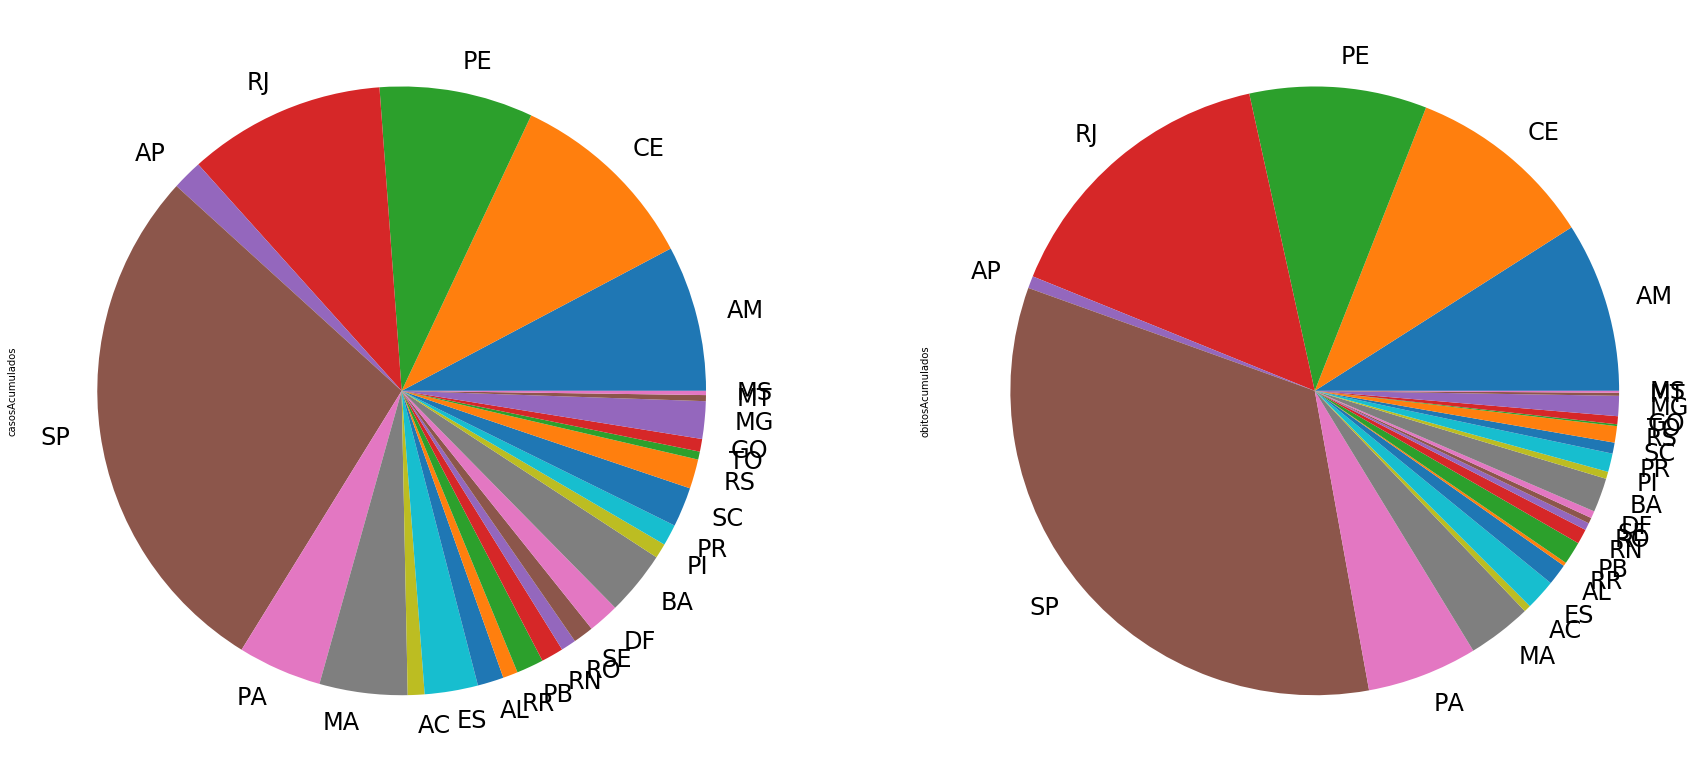

In [12]:
covidLastDayPie1 = covidLastDay[['estado','casosAcumulados', 'obitosAcumulados']]
covidLastDayPie1.set_index('estado', inplace=True)
plot = covidLastDayPie1.plot.pie(fontsize=24, subplots=True, layout=(1, 2), figsize=(30, 15), legend=None)

### Comparing Infections and Deaths per Million Inhabitans, per State

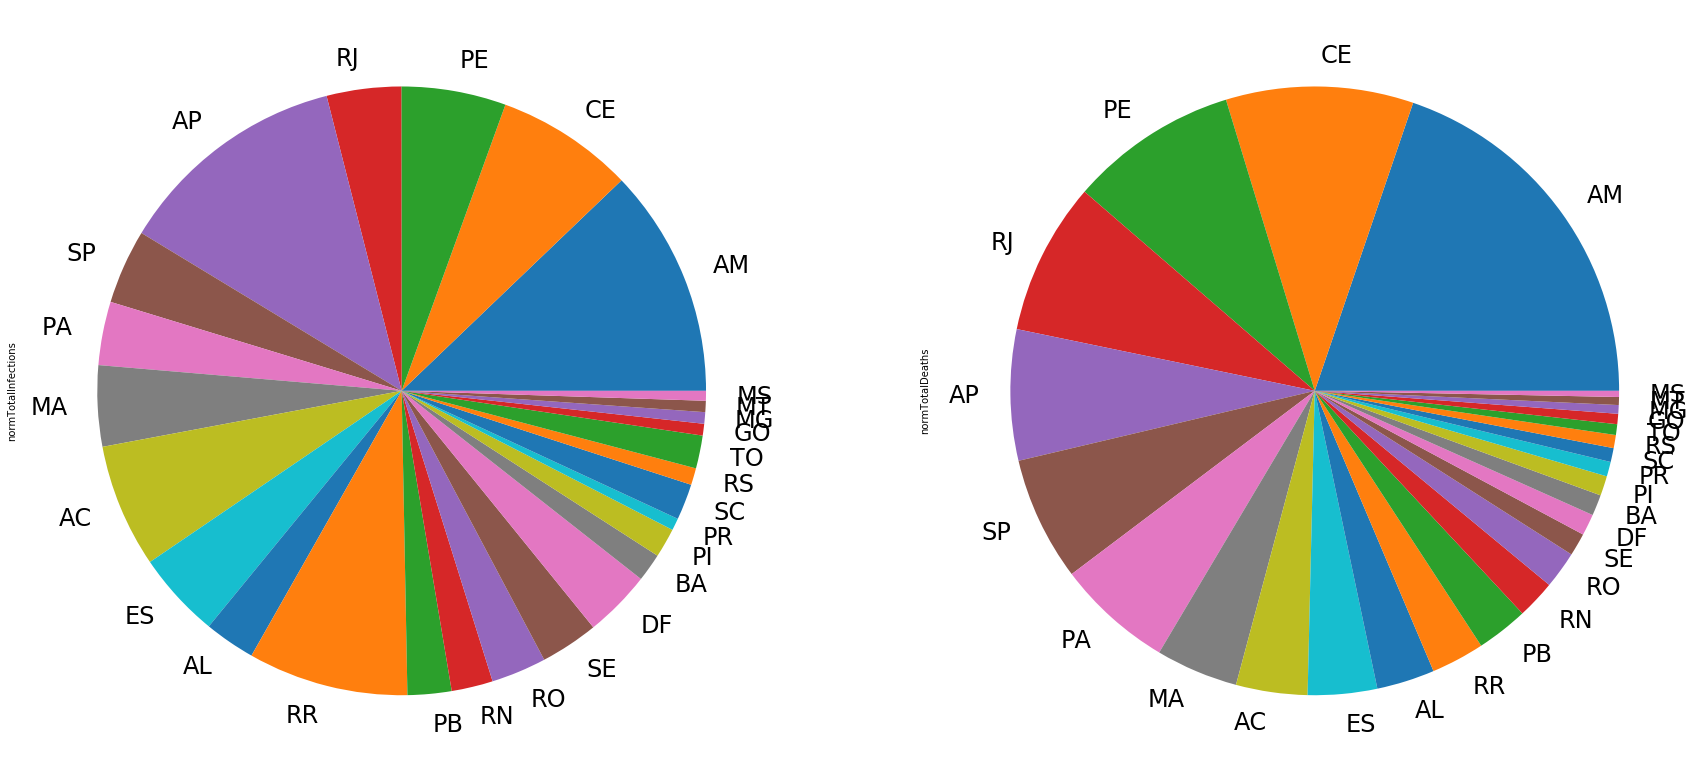

In [13]:
covidLastDayPie2 = covidLastDay[['estado','normTotalInfections', 'normTotalDeaths']]
covidLastDayPie2.set_index('estado', inplace=True)
plot = covidLastDayPie2.plot.pie(fontsize=24, subplots=True, layout=(1, 2), figsize=(30, 15), legend=None)

### Plots of daily infections and deaths

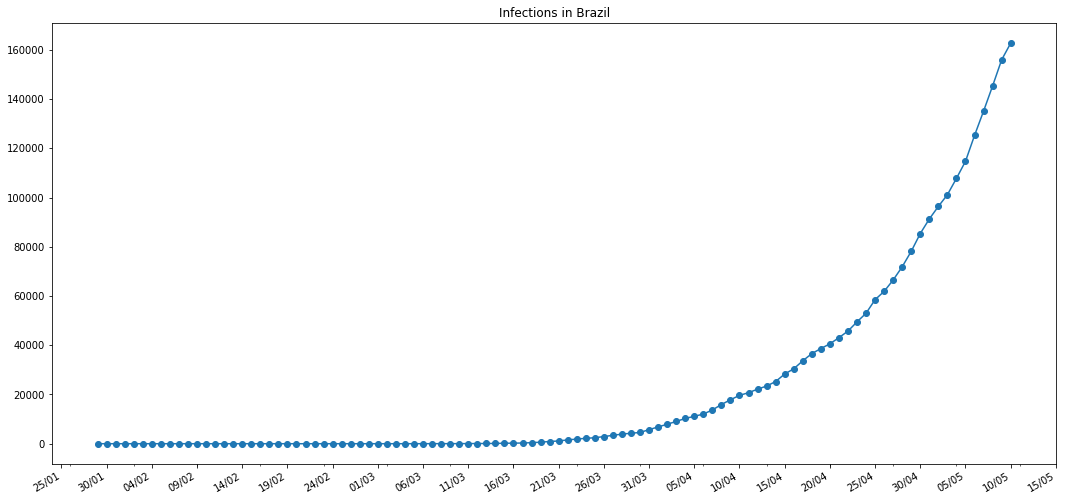

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

covid['data'] = pd.to_datetime(covid['data'], format='%Y-%m-%d')

covidByDayBR = covid[['data', 'casosAcumulados', 'obitosAcumulados']].groupby('data').sum()
covidByDayBR.reset_index(inplace=True)
covidByDayBR.set_index(['data'],inplace=True)

covidByDayRJ = covid.loc[covid['estado'] == 'RJ'][['data', 'casosAcumulados', 'obitosAcumulados', 'normTotalInfections', 'normTotalDeaths']]

axis = covidByDayBR.plot(legend=False, style='o-', figsize=(18, 9), y='casosAcumulados', title='Infections in Brazil')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

plt.show()

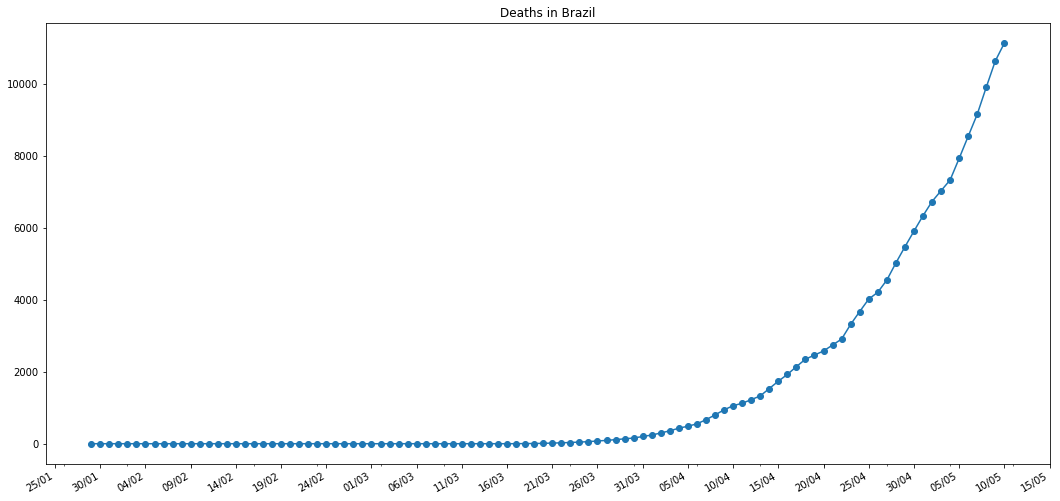

In [15]:
axis = covidByDayBR.plot(legend=False, style='o-',figsize=(18, 9), y='obitosAcumulados', title='Deaths in Brazil')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

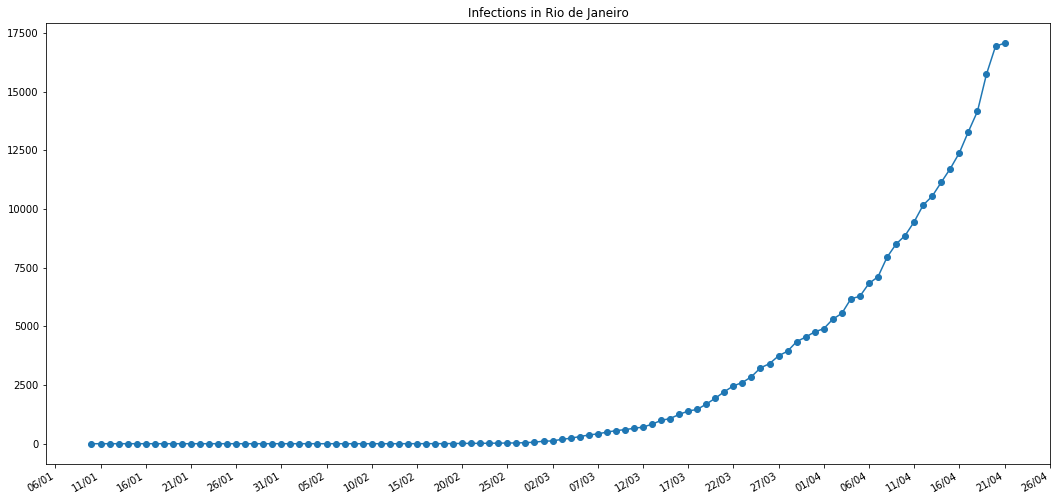

In [16]:
axis = covidByDayRJ.plot(legend=False,style='o-',figsize=(18, 9), y='casosAcumulados', title='Infections in Rio de Janeiro')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

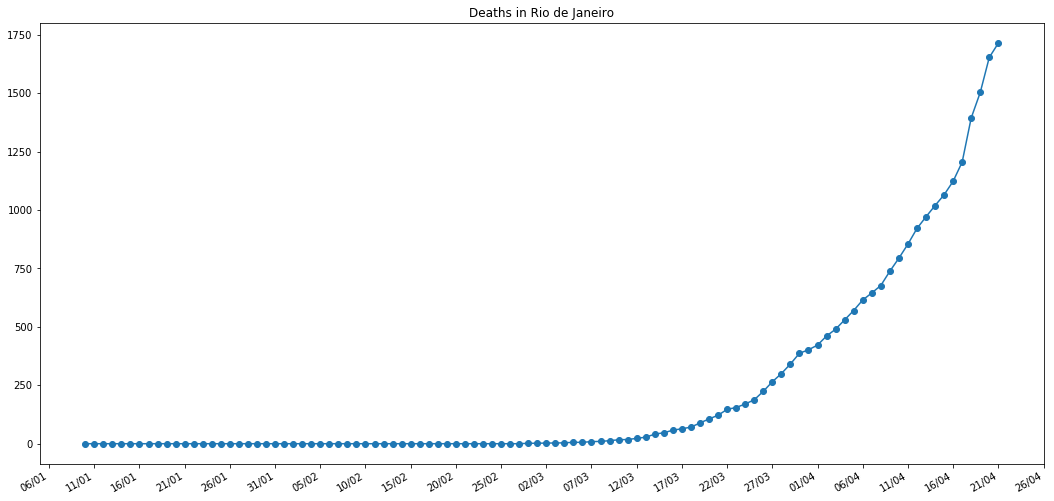

In [17]:
axis = covidByDayRJ.plot(legend=False, style='o-',figsize=(18, 9), y='obitosAcumulados', title='Deaths in Rio de Janeiro')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

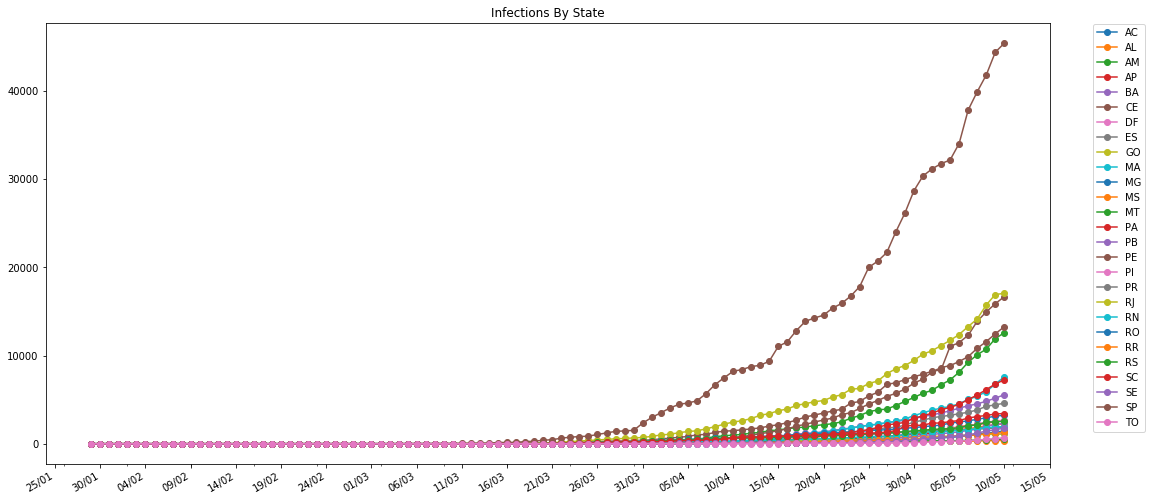

In [18]:
infectionsByDayStates = covid.pivot(index='data', columns='estado', values = 'casosAcumulados')
axis = infectionsByDayStates.plot(style='o-',figsize=(18, 9), title='Infections By State')
axis.legend(bbox_to_anchor=(1.1, 1.01))
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

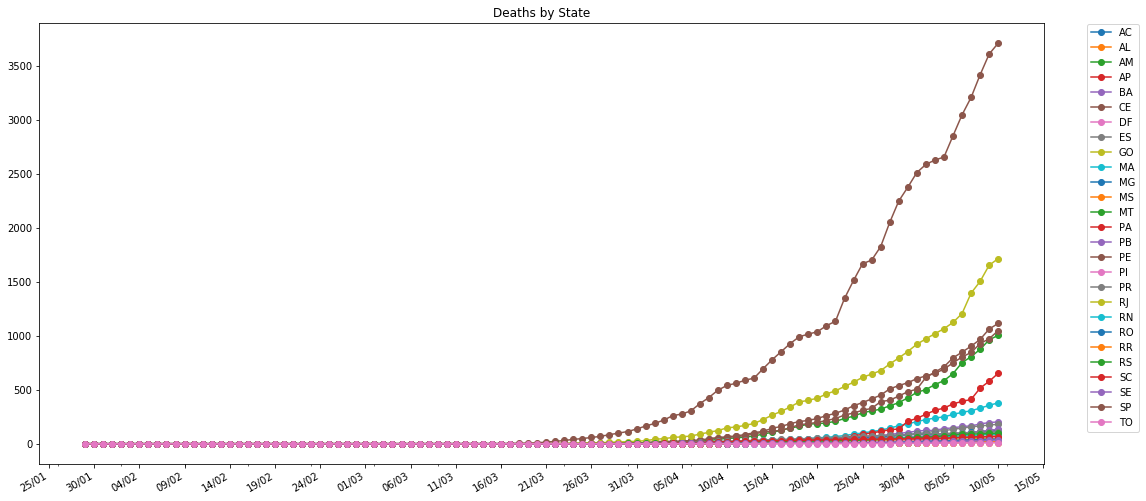

In [19]:
deathsByDayStates = covid.pivot(index='data', columns='estado', values = 'obitosAcumulados')
axis = deathsByDayStates.plot(style='o-',figsize=(18, 9), title='Deaths by State')
axis.legend(bbox_to_anchor=(1.1, 1.01))
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

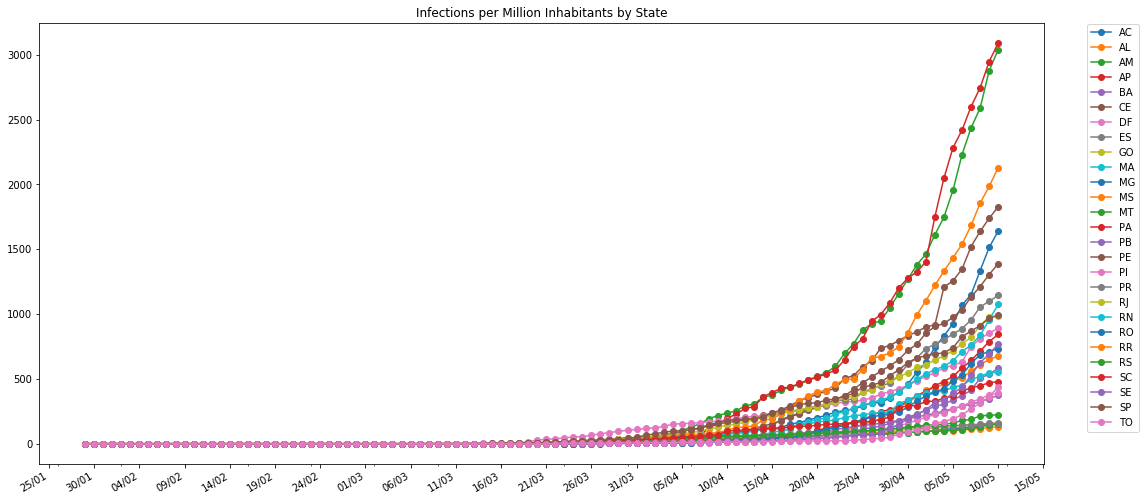

In [20]:
infectionsByDayStates = covid.pivot(index='data', columns='estado', values = 'normTotalInfections')
axis = infectionsByDayStates.plot(style='o-',figsize=(18, 9), title='Infections per Million Inhabitants by State')
axis.legend(bbox_to_anchor=(1.1, 1.01))
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

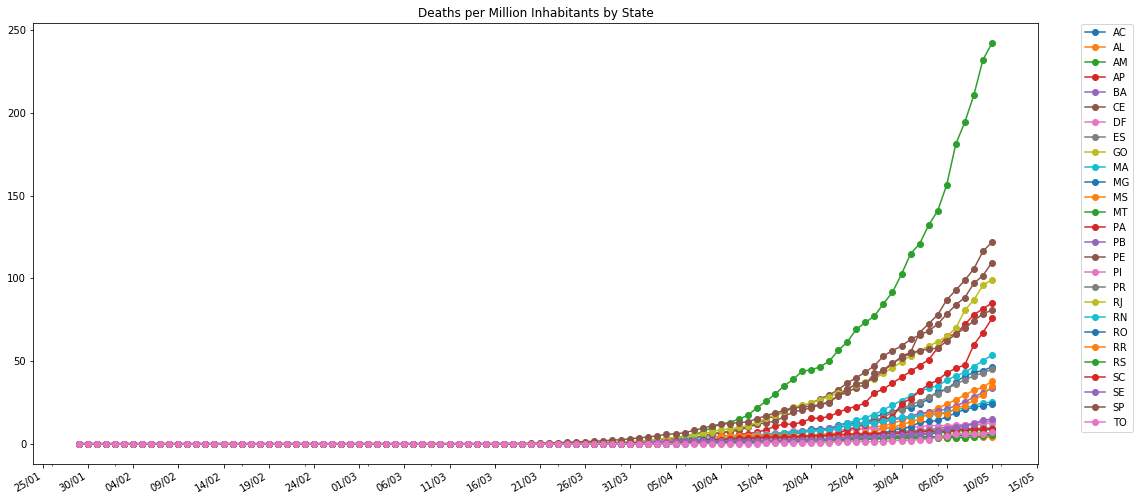

In [21]:
deathsByDayStates = covid.pivot(index='data', columns='estado', values = 'normTotalDeaths')
axis = deathsByDayStates.plot(style='o-',figsize=(18, 9), title='Deaths per Million Inhabitants by State')
axis.legend(bbox_to_anchor=(1.1, 1.01))
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

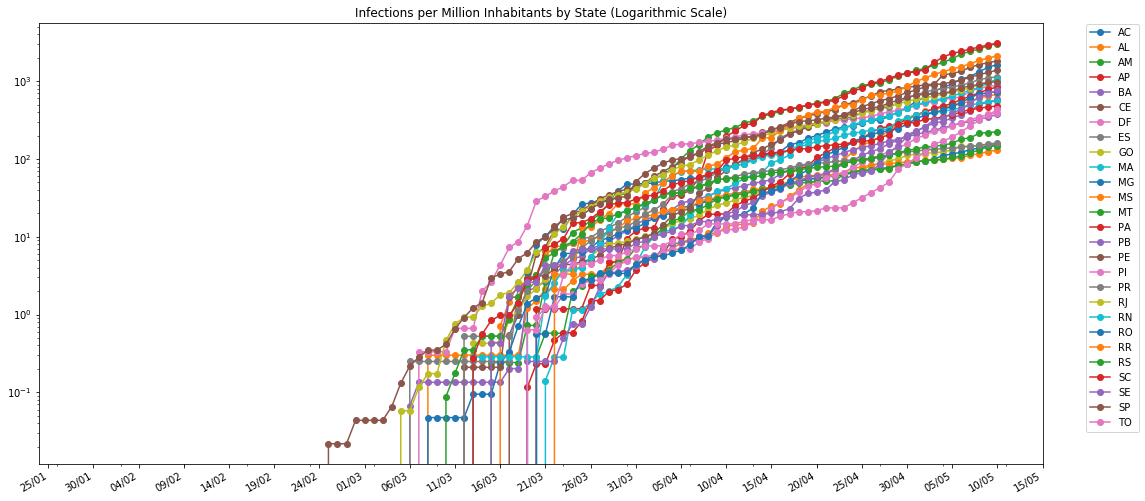

In [22]:
infectionsByDayStates = covid.pivot(index='data', columns='estado', values = 'normTotalInfections')
axis = infectionsByDayStates.plot(logy = True, style='o-',figsize=(18, 9), 
                              title='Infections per Million Inhabitants by State (Logarithmic Scale)')
axis.legend(bbox_to_anchor=(1.1, 1.01))
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

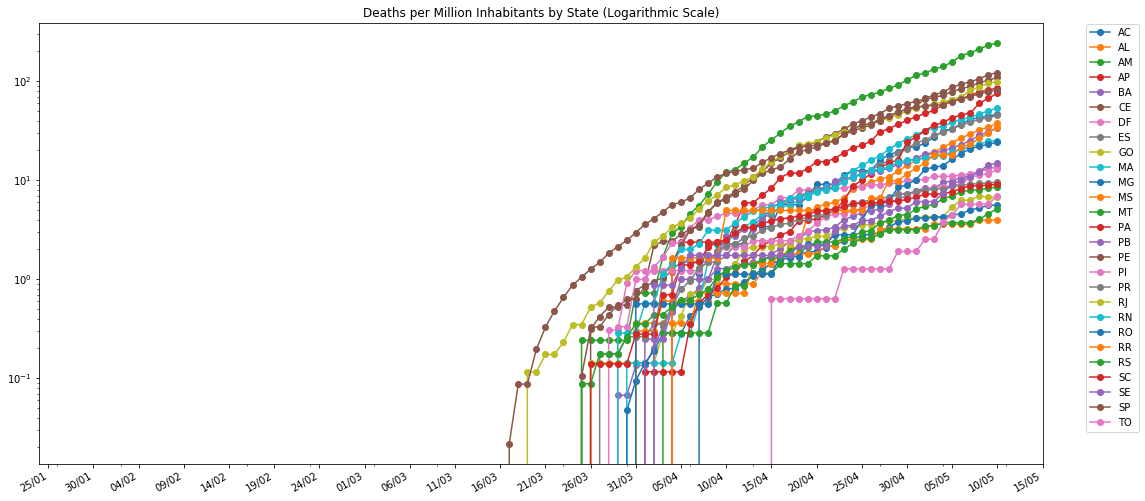

In [23]:
deathsByDayStates = covid.pivot(index='data', columns='estado', values = 'normTotalDeaths')
axis = deathsByDayStates.plot(logy = True, style='o-',figsize=(18, 9), 
                              title='Deaths per Million Inhabitants by State (Logarithmic Scale)')
axis.legend(bbox_to_anchor=(1.1, 1.01))
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

### Comparing tendencies of all states in the last 10 days
For the log of the deaths data of the last 10 daye for all states, I use Linear Regressions to estimate and compare how the situation is evolving. Higher coefficients means that situation is getting worse. 

In [24]:
last10Days = deathsByDayStates.tail(10)
last10Days['day'] = range(1,11)

display(last10Days)

estado,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,RJ,RN,RO,RR,RS,SC,SE,SP,TO,day
data,,,,,,,,,,,,,,,,,,,,,
2020-05-01,21.543538,15.880830,114.848319,43.749135,7.866570,55.299571,9.949364,23.888619,4.132023,28.833185,...,53.345094,15.968733,10.128149,13.206529,5.097898,6.699431,6.090410,54.683188,1.907346,1
2020-05-02,23.811279,17.379022,120.880269,47.296363,8.269984,67.235519,10.281010,25.381658,4.274507,31.659967,...,56.241136,16.824201,12.941524,14.857345,5.449477,7.257716,6.090410,56.316497,2.543128,2
2020-05-03,27.212890,19.176852,132.220334,50.843590,8.269984,72.601220,10.944301,28.367735,4.274507,33.497376,...,59.021336,17.394513,13.504199,18.158977,5.713161,7.257716,6.090410,57.209373,2.543128,3
2020-05-04,31.748371,21.573958,140.906341,57.938044,9.480225,77.966921,10.944301,30.358454,4.274507,35.193446,...,61.685695,17.679669,14.066874,18.158977,6.504214,7.257716,7.395497,57.797364,3.814692,4
2020-05-05,32.882242,23.971065,156.589410,65.032499,9.816404,87.055761,10.944301,33.095691,5.414375,38.302907,...,65.045103,19.390605,16.317574,18.158977,6.943688,7.676431,9.135614,62.087523,4.450474,5
2020-05-06,37.417724,26.667809,181.199764,66.214908,10.757703,92.859478,11.275946,36.081769,6.269276,41.129690,...,69.794612,20.531228,18.568274,21.460609,7.646846,8.234717,10.005673,66.312349,5.722039,6
2020-05-07,40.819335,29.364554,194.470053,72.126953,11.093881,98.882204,11.607592,38.570167,6.269276,43.108438,...,80.741651,21.671852,20.818973,23.111425,7.910531,8.793003,10.875731,69.818519,5.722039,7
2020-05-08,43.087076,32.360937,210.876956,78.038998,12.304122,105.780962,12.270883,41.058564,6.981694,46.641916,...,87.055022,23.097632,21.944323,26.413057,7.998426,8.793003,12.180819,74.391785,5.722039,8
2020-05-09,44.220946,34.158767,232.109419,81.586225,13.178186,116.293356,12.934174,42.800443,6.696727,50.175395,...,95.743148,24.808568,23.069673,29.714689,8.350005,8.932574,14.355965,78.573056,5.722039,9


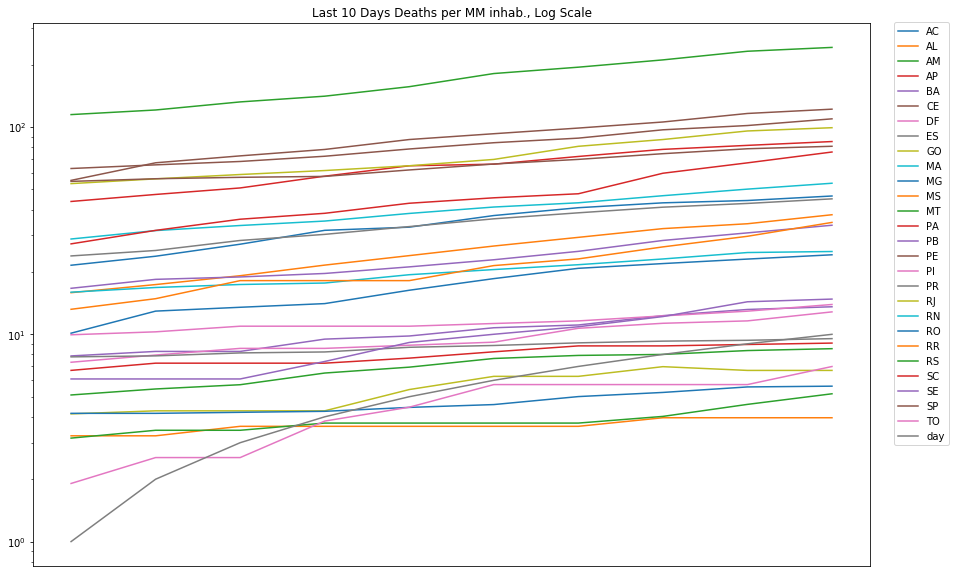

In [25]:
axis = last10Days.plot(logy=True, figsize=(15,10), title='Last 10 Days Deaths per MM inhab., Log Scale').legend(bbox_to_anchor=(1.1, 1.01))
plt.gca().xaxis.get_label().set_visible(False)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.show()

In [26]:
X_train = last10Days['day']
X_train = X_train.values.reshape(-1, 1)

data = {'state': [],
        'coefficient': []
       }
coef10days = pd.DataFrame (data, columns = ['state','coefficient'])


In [27]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Evaluating coefficients 
for col in last10Days.columns: 
    if col != 'day':
        last10Days[col + 'log'] = np.log(last10Days[col])
        regression_model.fit(X_train, last10Days[col + 'log'])
        coef10days = coef10days.append(pd.Series([col, regression_model.coef_[0]], index=coef10days.columns), ignore_index=True)



In [28]:
html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 40px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<h2> Predictions for the Near Future </h2>
<p style="font-size:18px"> Using the linear regression over the log data to estimate the number of deaths in 7, 14 e 30 days. </p>
</div>
'''
display(HTML(html_code))

#### All States

In [29]:
from datetime import timedelta

data = {'date': [],
        'state': [],
        'predictedDeaths': []
       }
predictedDeaths = pd.DataFrame (data, columns = ['date','state', 'predictedDeaths'])

more7Days = 17;
more14Days = 24;
more30Days = 40;
dateMore7Days = (datetime.strptime(lastDay, '%Y-%m-%d') + timedelta(days=7)).strftime("%d/%m/%Y")
dateMore14Days = (datetime.strptime(lastDay, '%Y-%m-%d') + timedelta(days=14)).strftime("%d/%m/%Y")
dateMore30Days = (datetime.strptime(lastDay, '%Y-%m-%d') + timedelta(days=30)).strftime("%d/%m/%Y")

deathsByState = covid.pivot(index='data', columns='estado', values = 'obitosAcumulados')
last10Days = deathsByState.tail(10)
last10Days['day'] = range(1,11)

for col in last10Days.columns: 
    if col != 'day':
        last10Days[col + 'log'] = np.log(last10Days[col])
        regression_model.fit(X_train, last10Days[col + 'log'])
        
        xpredict = np.array([more7Days])
        xpredict = xpredict.reshape(-1,1)
        prediction = regression_model.predict(xpredict)
        predictedDeaths = predictedDeaths.append(pd.Series([dateMore7Days, col, int(np.exp(prediction[0]))], index=predictedDeaths.columns), ignore_index=True)
        
        xpredict = np.array([more14Days])
        xpredict = xpredict.reshape(-1,1)
        prediction = regression_model.predict(xpredict)
        predictedDeaths = predictedDeaths.append(pd.Series([dateMore14Days, col, int(np.exp(prediction[0]))], index=predictedDeaths.columns), ignore_index=True)
        
        xpredict = np.array([more30Days])
        xpredict = xpredict.reshape(-1,1)
        prediction = regression_model.predict(xpredict)
        predictedDeaths = predictedDeaths.append(pd.Series([dateMore30Days, col, int(np.exp(prediction[0]))], index=predictedDeaths.columns), ignore_index=True)
        
predictedDeaths
predictedDeathsOut = predictedDeaths.pivot(index='state', columns='date', values = 'predictedDeaths')

predictedDeathsOut = predictedDeathsOut[[dateMore7Days, dateMore14Days, dateMore30Days]]

predictedDeathsBrazil = predictedDeathsOut.sum().reset_index(name='predictedDeaths')
predictedDeathsBrazil = predictedDeathsBrazil.append(pd.Series([lastDayFormatted, deathsBR], index=predictedDeathsBrazil.columns), ignore_index=True)
predictedDeathsBrazil.set_index('date', inplace=True)
predictedDeathsBrazilOut = predictedDeathsBrazil.transpose()
predictedDeathsBrazilOut = predictedDeathsBrazilOut[[lastDayFormatted, dateMore7Days, dateMore14Days, dateMore30Days]]

predictedDeathsOut['state'] = predictedDeathsOut.index
covidLastDayOut = covidLastDay[['estado', 'obitosAcumulados']][['estado', 'obitosAcumulados']]
covidLastDayOut
predictedDeathsOut = predictedDeathsOut.merge(covidLastDayOut, left_on='state', right_on='estado')
predictedDeathsOut = predictedDeathsOut[['estado', 'obitosAcumulados', dateMore7Days, dateMore14Days, dateMore30Days]]
predictedDeathsOut.columns = ['State', lastDayFormatted, dateMore7Days, dateMore14Days, dateMore30Days]

pd.options.display.float_format = '{0:g}'.format
display(predictedDeathsOut)





,State,10/05/2020,17/05/2020,24/05/2020,09/06/2020
0,AC,41,81,150,610
1,AL,126,255,508,2438
2,AM,1004,1932,3610,15064
3,AP,72,128,220,749
4,BA,202,322,508,1439
5,CE,1114,2055,3662,13713
6,DF,42,50,63,107
7,ES,181,313,521,1672
8,GO,47,83,133,398
9,MA,379,606,972,2863


#### Brazil

In [30]:
predictedDeathsBrazilOut.columns = [lastDayFormatted, dateMore7Days, dateMore14Days, dateMore30Days]
predictedDeathsBrazilOut.reset_index(inplace=True)
predictedDeathsBrazilOut.drop('index', axis=1, inplace=True)
display(predictedDeathsBrazilOut)

,10/05/2020,17/05/2020,24/05/2020,09/06/2020
0,11123,17990,29555,98968


In [31]:
coef10days.sort_values('coefficient',ascending=False,inplace=True)
coef10days.set_index('state', inplace=True)

In [32]:
html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 40px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<h2> Clustering the states in 3 classes according to the calculated coefficients </h2>
<p style="font-size:18px">  A higher coefficient means a worse tendency for the deaths. </p>
</div>
'''
display(HTML(html_code))

In [33]:
coef10daysData = pd.DataFrame(coef10days)
coef10daysData['state'] = coef10daysData.index
coef10daysData = coef10daysData.reset_index(level=0, drop=True)
coef10daysData = coef10daysData[['state', 'coefficient']]

coef10daysData['myClass'] = kmeans.fit_predict(coef10daysData[['coefficient']])
worstClass = coef10daysData.iloc[0]['myClass']
bestClass = coef10daysData.iloc[-1]['myClass']

display(coef10daysData.style.apply(highlight, axis=1))

,state,coefficient,myClass
0,TO,0.138742,0
1,SE,0.113343,0
2,PA,0.107277,0
3,RR,0.0987986,0
4,AL,0.0980118,0
5,RO,0.0946477,0
6,AM,0.089275,0
7,AC,0.0874927,0
8,CE,0.0825164,2
9,PB,0.0773469,2


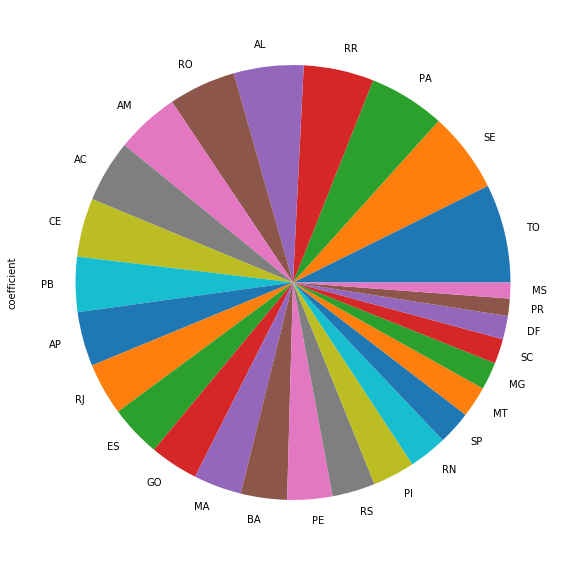

In [34]:
_ = coef10days.plot.pie(y='coefficient', figsize=(10, 10), legend=False)

### R curve
Estimating R, that represents the basic reproduction rate of the disease, using a generation time of 14 days. It roughly estimates how many people are infected by one infected person after 14 days.

It is a very simple and imprecise approach. And, specially, the values in the begining of the plot should be disregarded, because the fist notifications of the infections are not representative or reliable.

The plot is more of a tendency indicator, than a real value estimator. 

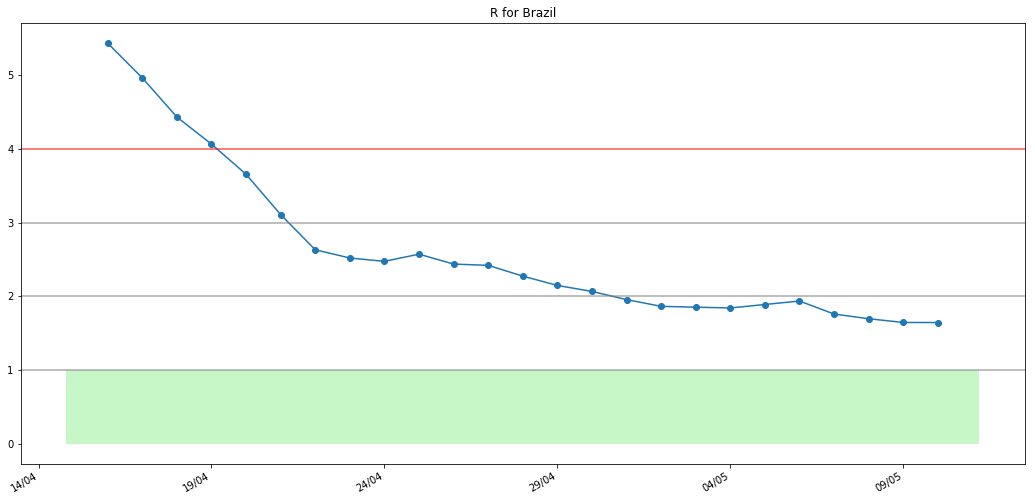

In [35]:

data = {'date': [],
        'value': []
       }
R_Brazil = pd.DataFrame (data, columns = ['date','value'])

# Generation Time
gt = 14

covidDeathsBR = covid.groupby('data')['obitosAcumulados'].sum().reset_index(name ='obitosAcumulados')

for day in range(covidDeathsBR.shape[0]):
    if day >= gt:
        if covidDeathsBR.at[day-gt,'obitosAcumulados'] > 0:
            Rvalue = float(covidDeathsBR.at[day,'obitosAcumulados'])/float(covidDeathsBR.at[day-gt,'obitosAcumulados'])-1.
            if Rvalue <= 6:
                R_Brazil = R_Brazil.append(pd.Series([covidDeathsBR.at[day, 'data'], Rvalue], index=R_Brazil.columns), ignore_index=True)

R_Brazil['date'] = pd.to_datetime(R_Brazil['date'], format='%Y-%m-%d')

R_Brazil.set_index('date', inplace=True)
axis = R_Brazil.plot(style='o-', figsize=(18, 9), legend=False, y='value', title='R for Brazil')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.axhline(1.0, color='gray', lw=2, alpha=0.5)
axis.axhline(2.0, color='gray', lw=2, alpha=0.5)
axis.axhline(3.0, color='gray', lw=2, alpha=0.5)
axis.axhline(4.0, color='red', lw=2, alpha=0.5)
axis.fill_between(axis.get_xlim(), 0., 1., facecolor='lightgreen', alpha=0.5)
axis.xaxis.get_label().set_visible(False)
plt.show()




In [36]:
data = {'date': [],
        'state': [],
        'value': []
       }
R_States = pd.DataFrame (data, columns = ['date','state', 'value'])


for state in covid.estado.unique():
    covidState = covid.loc[covid['estado'] == state]

    covidDeathsState = covidState.groupby('data')['obitosAcumulados'].sum().reset_index(name ='obitosAcumulados')
    for day in range(covidDeathsState.shape[0]):
        if day >= gt:
            if covidDeathsState.at[day-gt,'obitosAcumulados'] > 0:
                Rvalue = float(covidDeathsState.at[day,'obitosAcumulados'])/float(covidDeathsState.at[day-gt,'obitosAcumulados']) - 1.
                R_States = R_States.append(pd.Series([covidDeathsState.at[day, 'data'], state, Rvalue], index=R_States.columns), ignore_index=True)


R_States['date'] = pd.to_datetime(R_States['date'], format='%Y-%m-%d')

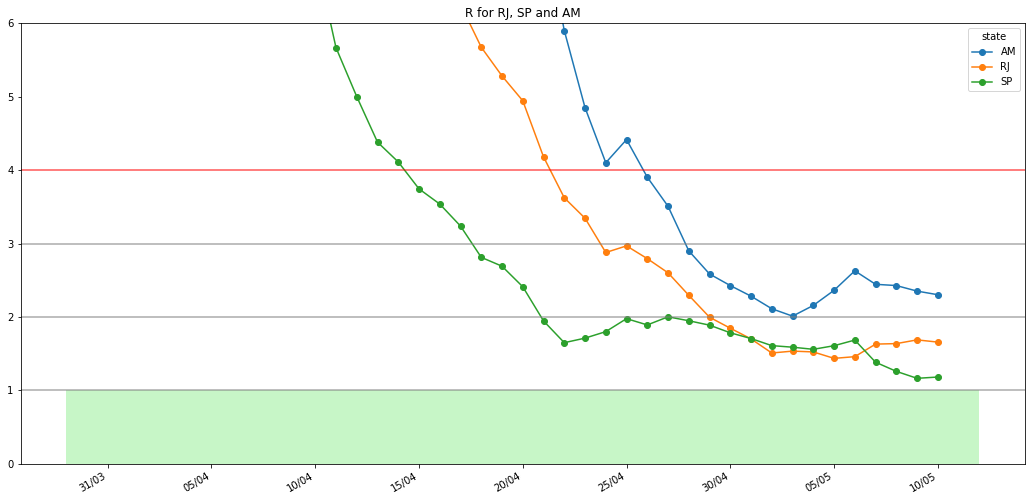

In [37]:
R_StatesGroup = R_States.loc[R_States['state'].isin(['RJ', 'SP', 'AM'])]
R_StatesGroup = R_StatesGroup.pivot(index='date', columns='state', values = 'value')

axis = R_StatesGroup.plot(style='o-', figsize=(18, 9), title='R for RJ, SP and AM')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.axhline(1.0, color='gray', lw=2, alpha=0.5)
axis.axhline(2.0, color='gray', lw=2, alpha=0.5)
axis.axhline(3.0, color='gray', lw=2, alpha=0.5)
axis.axhline(4.0, color='red', lw=2, alpha=0.5)
axis.fill_between(axis.get_xlim(), 0., 1., facecolor='lightgreen', alpha=0.5)
plt.ylim((0,6))
axis.xaxis.get_label().set_visible(False)
plt.show()